In [1]:
from scipy.sparse import load_npz, vstack
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import load_npz
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import learning_curve, validation_curve
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.decomposition import PCA

In [2]:
fake_features = load_npz('fake_features.npz')
true_features = load_npz('true_features.npz')
print(fake_features.shape)

(22854, 43504)


In [20]:
def plot_confusion_matrix(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fake News', 'True News'],
                yticklabels=['Fake News', 'True News'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.title('Matrice de Confusion')
    plt.tight_layout()
    plt.show()

# 2. Courbe ROC
def plot_roc_curve(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# 3. Courbe Précision-Rappel
def plot_precision_recall_curve(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label=f'AUC = {pr_auc:.3f}')
    plt.axhline(y=sum(y_test)/len(y_test), color='navy', linestyle='--', label='Niveau de base')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Rappel')
    plt.ylabel('Précision')
    plt.title('Courbe Précision-Rappel')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.show()

# 4. Coefficients du modèle (si vous avez accès aux noms des features)
def plot_top_features(model, feature_names, top_n=20):
    # Récupérer les coefficients du modèle
    coefficients = model.coef_[0]
    
    # Créer un DataFrame avec les features et leurs coefficients
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(coefficients)  # Valeur absolue pour l'importance
    })
    
    # Trier par importance décroissante et prendre les top_n
    top_features = feature_importance.sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Features les plus importantes')
    plt.tight_layout()
    plt.show()

# 5. Courbe d'apprentissage
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy')
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, 
             label='Score entraînement')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, 
                     alpha=0.15, color='blue')
    
    plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, 
             label='Score validation')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, 
                     alpha=0.15, color='green')
    
    plt.xlabel('Nombre d\'exemples d\'entraînement')
    plt.ylabel('Accuracy')
    plt.title('Courbe d\'apprentissage')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.show()

# 6. Visualisation des erreurs de classification
def plot_classification_errors(X_test, y_test, y_pred, model, n_features=2):
    """
    Visualise les erreurs de classification dans un espace à 2 dimensions.
    Utilise PCA pour réduire la dimensionnalité si nécessaire
    """
    
    
    # Réduire à 2 dimensions pour la visualisation
    pca = PCA(n_components=n_features)
    X_reduced = pca.fit_transform(X_test.toarray())
    
    # Calculer les probabilités pour la taille des points
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Créer un DataFrame pour faciliter le plotting
    df = pd.DataFrame({
        'x': X_reduced[:, 0],
        'y': X_reduced[:, 1],
        'true_label': y_test,
        'pred_label': y_pred,
        'proba': y_proba
    })
    
    # Ajouter une colonne pour identifier les classifications correctes et incorrectes
    df['correct'] = df['true_label'] == df['pred_label']
    
    plt.figure(figsize=(10, 8))
    
    # Tracer les prédictions correctes
    correct = df[df['correct']]
    plt.scatter(correct['x'], correct['y'], c=correct['true_label'], 
                 alpha=0.6, marker='o', 
                edgecolor='k', linewidth=0.5,
                cmap='coolwarm', label='Correct')
    
    # Tracer les erreurs
    errors = df[~df['correct']]
    plt.scatter(errors['x'], errors['y'], c=errors['true_label'], 
                s=errors['proba']*100, alpha=0.8, marker='X', 
                edgecolor='k', linewidth=1.5,
                cmap='coolwarm', label='Erreur')
    
    plt.colorbar(label='Classe réelle (0=Fake, 1=True)')
    plt.xlabel(f'Composante principale 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Composante principale 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Visualisation des erreurs de classification')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [21]:

# 2. Concaténer les features (verticalement)
X = vstack([fake_features, true_features])
print(X.shape)
# 3. Créer les labels : 0=fake, 1=true
y_fake = np.zeros(fake_features.shape[0])  # Vecteur de 0 pour les fake
y_true = np.ones(true_features.shape[0])   # Vecteur de 1 pour les true
y = np.concatenate([y_fake, y_true])

# 4. Séparer en train/test (stratifié pour garder les proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

(44270, 43504)


# Logistic Regression Model Training and Evaluation

In [22]:
from scipy.sparse import load_npz, vstack
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report

# 2. Concaténer les features (verticalement)
X = vstack([fake_features, true_features])
print(X.shape)
# 3. Créer les labels : 0=fake, 1=true
y_fake = np.zeros(fake_features.shape[0])  # Vecteur de 0 pour les fake
y_true = np.ones(true_features.shape[0])   # Vecteur de 1 pour les true
y = np.concatenate([y_fake, y_true])

# 4. Séparer en train/test (stratifié pour garder les proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Entraîner le modèle (avec gestion des données creuses)
model =LogisticRegression(
    solver='liblinear',  # Meilleur choix pour les données creuses
    penalty='l2',        # Régularisation L2
    max_iter=1000,       # Nombre d'itérations accru
    random_state=42
)
model.fit(X_train, y_train)

# 6. Évaluer
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

(44270, 43504)
Accuracy: 0.9918680822227242

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4571
         1.0       0.99      0.99      0.99      4283

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



In [19]:
dump(model,'models/Lregression_model.joblib')

['models/Lregression_model.joblib']

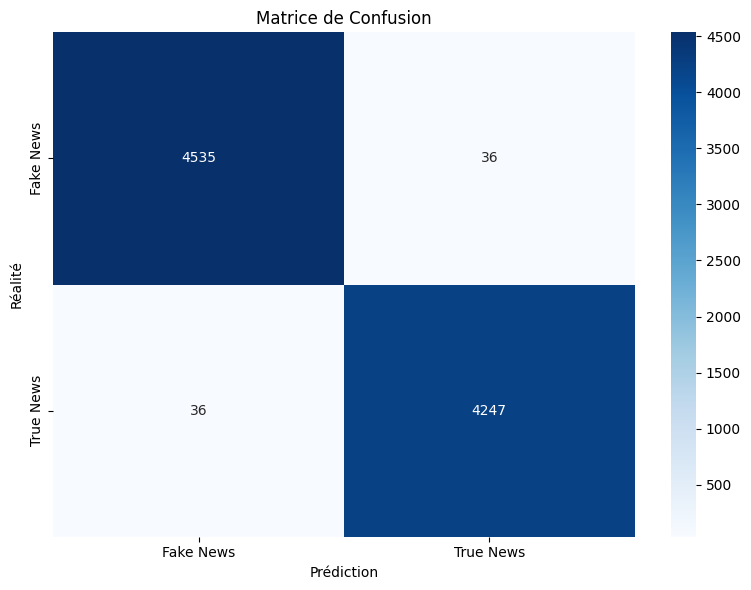

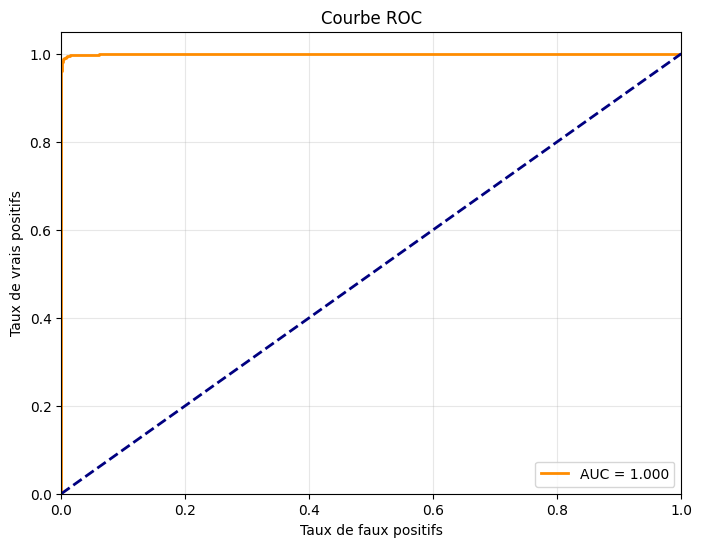

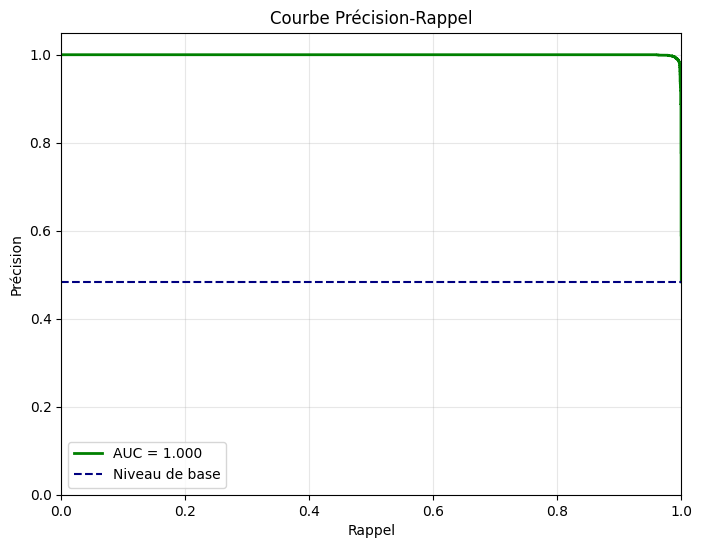

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

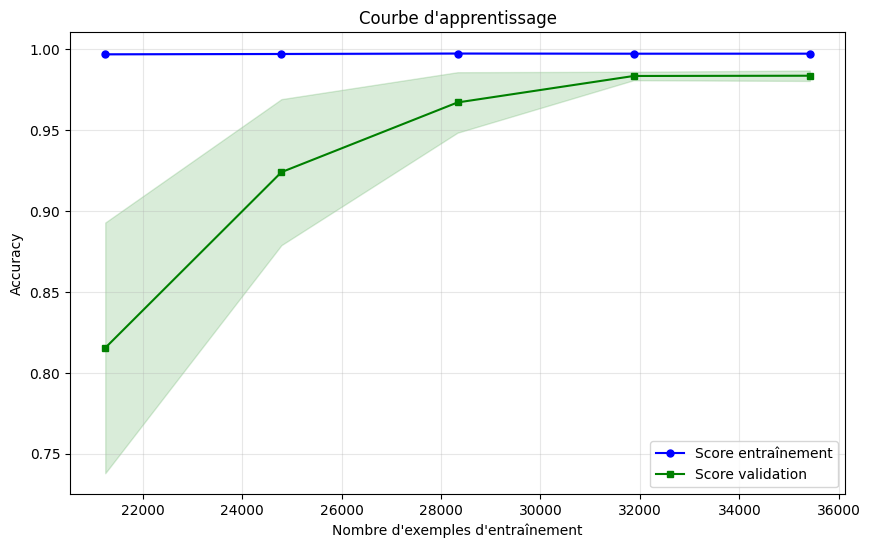

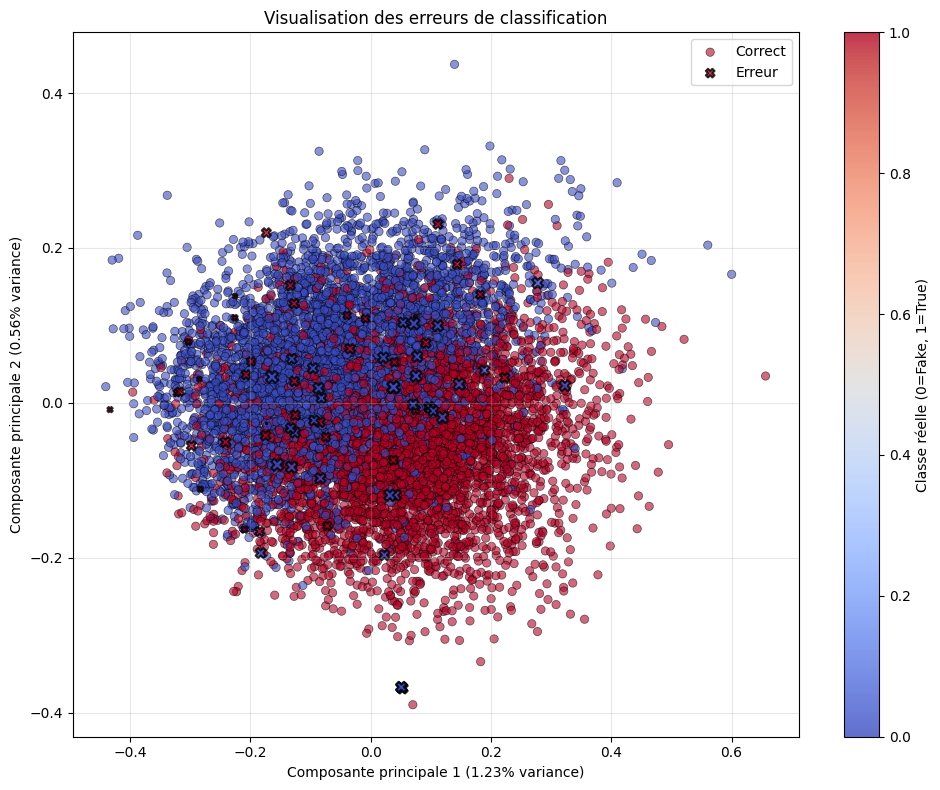

In [23]:
# Afficher les métriques
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(model, X_test, y_test)
plot_precision_recall_curve(model, X_test, y_test)

# Si vous avez accès aux noms des features, sinon commentez cette fonction
# vectorizer = TfidfVectorizer()  # Votre vectorizer si disponible
# feature_names = vectorizer.get_feature_names_out()
# plot_top_features(model, feature_names, top_n=20)

# Courbe d'apprentissage (peut prendre du temps sur de grands datasets)
plot_learning_curve(model, X, y)

# Visualisation des erreurs
plot_classification_errors(X_test, y_test, y_pred, model)

# Support Vector Machine (SVM) Model Training and Evaluation

In [ ]:

from scipy.sparse import load_npz, vstack
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report

# 2. Concaténer les features (verticalement)
X = vstack([fake_features, true_features])
print(X.shape)
# 3. Créer les labels : 0=fake, 1=true
y_fake = np.zeros(fake_features.shape[0])  # Vecteur de 0 pour les fake
y_true = np.ones(true_features.shape[0])   # Vecteur de 1 pour les true
y = np.concatenate([y_fake, y_true])

# 4. Séparer en train/test (stratifié pour garder les proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Entraîner le modèle (avec gestion des données creuses)
model = SVC(
    kernel='sigmoid',           # Noyau RBF (Gaussien). Alternatives: 'linear', 'poly', 'sigmoid'
    C=1.0,                 # Paramètre de régularisation (plus C est petit, plus le modèle est régularisé)
    gamma='scale',         # 'scale' = 1/(n_features * X.var()), 'auto' = 1/n_features
    degree=3,              # Si kernel='poly', degré du polynôme
    coef0=0.0,            # Terme indépendant dans 'poly'/'sigmoid'
    shrinking=True,        # Utilise l'heuristique de réduction pour accélérer l'entraînement
    probability=True,     # Si True, permet predict_proba (mais ralentit l'entraînement)
    max_iter=100,           #-1 = pas de limite (mais peut diverger)
    random_state=42
)
model.fit(X_train, y_train)

# 6. Évaluer
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

(44270, 43504)


C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.9526767562683532

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      4571
         1.0       0.94      0.96      0.95      4283

    accuracy                           0.95      8854
   macro avg       0.95      0.95      0.95      8854
weighted avg       0.95      0.95      0.95      8854



In [16]:
dump(model,'models/svm_model.joblib')

['models/svm_model.joblib']

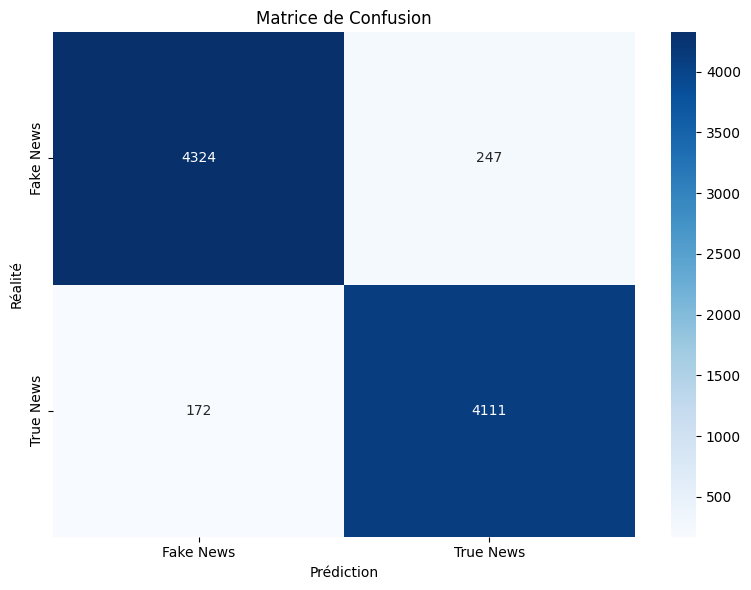

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-package

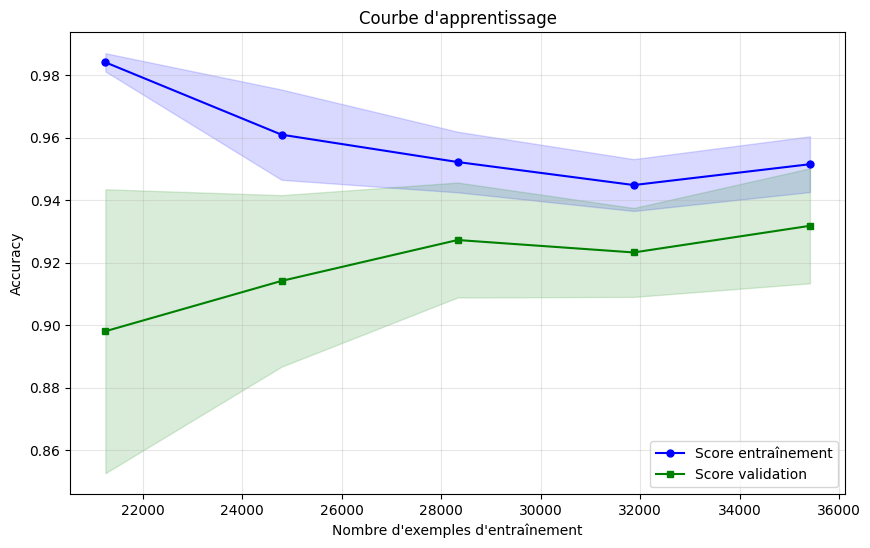

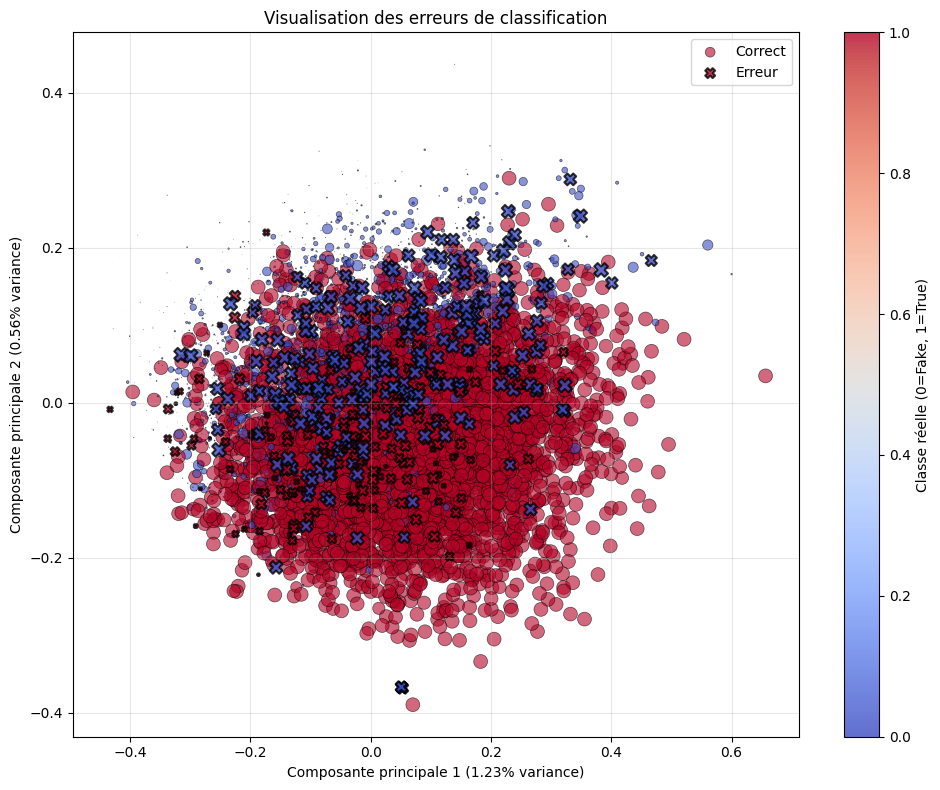

In [ ]:
# Afficher les métriques
plot_confusion_matrix(y_test, y_pred)
# Si vous avez accès aux noms des features, sinon commentez cette fonction
# vectorizer = TfidfVectorizer()  # Votre vectorizer si disponible
# feature_names = vectorizer.get_feature_names_out()
# plot_top_features(model, feature_names, top_n=20)

# Courbe d'apprentissage (peut prendre du temps sur de grands datasets)
plot_learning_curve(model, X, y)

# Visualisation des erreurs
plot_classification_errors(X_test, y_test, y_pred, model)

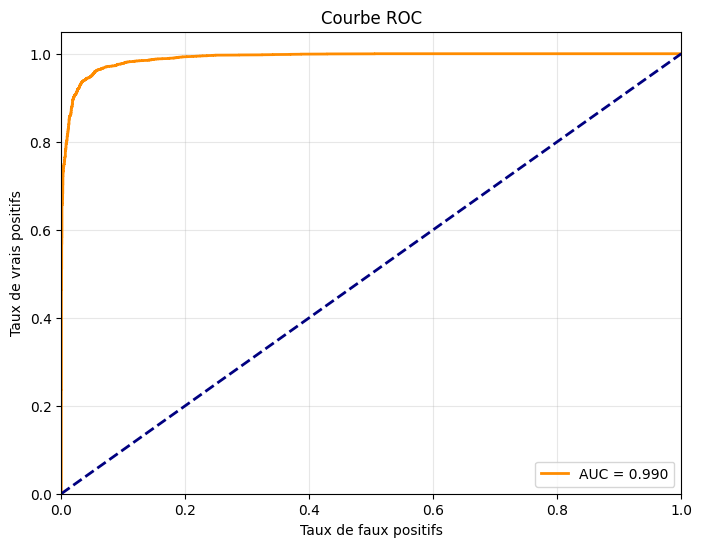

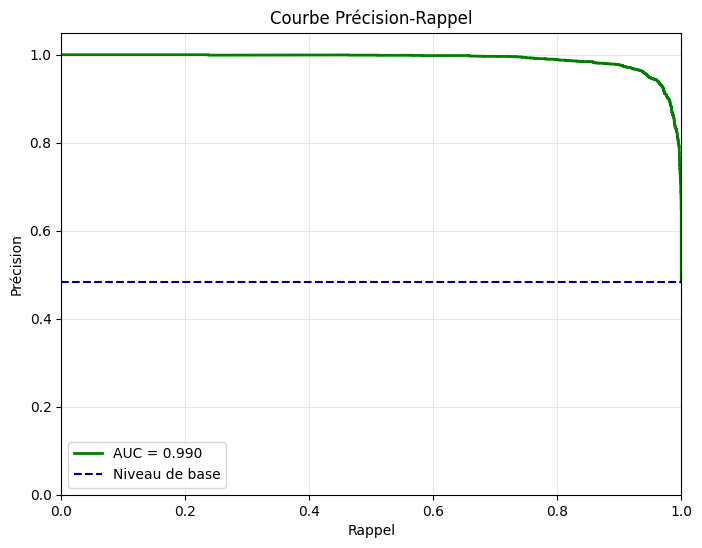

In [7]:
plot_roc_curve(model, X_test, y_test)
plot_precision_recall_curve(model, X_test, y_test)

In [1]:
import re
from nltk.corpus import stopwords as nltk_stopwords
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stopwords
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords

# 1. Initialisation rapide de spaCy (sans composants inutiles)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])

def clean_word(word):
    """Nettoie le mot : conserve uniquement les lettres alphabétiques et met en minuscule"""
    return re.sub(r'[^a-z]', '', word.lower())

def get_combined_stopwords():
    """Combine les stopwords de toutes les sources et les nettoie"""
    # Sources de stopwords
    sources = {
        "nltk": set(nltk_stopwords.words('english')),
        "spacy": set(nlp.Defaults.stop_words),
        "sklearn": set(sklearn_stopwords),
        "gensim": set(gensim_stopwords)
    }
    
    # Combinaison et nettoyage
    combined = set()
    for source_words in sources.values():
        for word in source_words:
            cleaned = clean_word(word)  # Nettoie le mot
            if cleaned and len(cleaned):  # Ignore les mots vides ou trop courts
                combined.add(cleaned)
    
    return sorted(combined)
s_words = get_combined_stopwords()
print((s_words))

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', 'arent', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'ca', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldn', 'couldnt', 'cry', 'd', 'de', 'describe', 'detail', 'did', 'didn', 'didnt', 'do', 'does', 'doesn', 'doesnt', 'doing', 'don', 'done', 'dont', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'fin

In [2]:
import joblib
import spacy
import string 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd 
import scipy.sparse as sp
import numpy as np
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
s_words = get_combined_stopwords()
def text_cleaning(text) : 
    global nlp,s_words
    # nltk.download('stopwords')
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)  # \w = alphanumérique, \s = espace
    cleaned_text = []
    
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)
    cleaned_text = [nlp(word)[0].lemma_ for word in text_no_punct.split() if word not in s_words]
    return " ".join(cleaned_text)
def text_to_decvect(text,model):
 vector = model.infer_vector(text.split())
# Afficher le vecteur      
 return vector   
def prepare_text(text,title):
    text = text_cleaning(text)
    title = text_cleaning(title)
    tf_idf_vectorizer = joblib.load("tf_idf_vectorizer.pkl")
    model = Doc2Vec.load("mon_modele_doc2vec.model")
    vects = tf_idf_vectorizer.transform([title,text]).toarray()
    docvects = [text_to_decvect(title,model),text_to_decvect(text,model)]
    
    simcos1 = cosine_similarity([vects[0]],[vects[1]])[0][0]
    print(simcos1)
    simcos2 = cosine_similarity([docvects[0]],[docvects[1]])[0][0]
    return np.hstack([np.array([vects[0]]), np.array([vects[1]]), np.array([[simcos1, simcos2]])])

# Définition et Entraînement d'un Modèle de Deep Learning (Keras)

In [3]:
import keras

from keras.models import Sequential,load_model
from keras.layers import Dense ,Dropout
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import datetime
from tensorflow.keras.callbacks import TensorBoard

In [4]:
import pandas as pd
class Model_fak_news :
    def __init__(self,input_size) :
        self.model = Sequential()
        self.model.add(Dense(1024, activation='relu', input_shape=(input_size,), kernel_regularizer=l2(0.0001)))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(512,activation='relu',kernel_regularizer=l2(0.0001)))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(128,activation='relu',kernel_regularizer=l2(0.0001)))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(64,activation='relu',kernel_regularizer=l2(0.0001)))
        self.model.add(Dense(2,activation='softmax'))
    def compile(self):
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    def fit(self,X_train,y_train,x_test,y_test,epoch,bach,callbacks):
       
        h = self.model.fit(X_train, y_train, validation_data=(x_test,y_test), verbose=2,batch_size=bach,epochs = epoch,callbacks=callbacks)
        return h
          
        

In [5]:

# 2. Concaténer les features (verticalement)
X = vstack([fake_features, true_features])
print(X.shape)
# 3. Créer les labels : 0=fake, 1=true
# 3. Créer les labels one-hot : [0, 1] = fake, [1, 0] = true
y_fake = np.tile([0, 1], (fake_features.shape[0], 1))  # shape = (n_fake, 2)
y_true = np.tile([1, 0], (true_features.shape[0], 1))  # shape = (n_true, 2)

# Fusionner verticalement pour avoir tous les labels
y = np.vstack([y_fake, y_true])

# 4. Séparer en train/test (stratifié pour garder les proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

(44270, 43504)


In [6]:
model = Model_fak_news(X.shape[1])
model.compile()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(X_train,y_train,X_test,y_test,15,10000,callbacks=[tensorboard_callback])
model.model.save("models/deepmodelclasifier.h5")

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
4/4 - 114s - 28s/step - accuracy: 0.7181 - loss: 0.9339 - val_accuracy: 0.9382 - val_loss: 0.7089
Epoch 2/15
4/4 - 113s - 28s/step - accuracy: 0.9543 - loss: 0.5443 - val_accuracy: 0.9753 - val_loss: 0.2749
Epoch 3/15
4/4 - 104s - 26s/step - accuracy: 0.9867 - loss: 0.2260 - val_accuracy: 0.9887 - val_loss: 0.1906
Epoch 4/15
4/4 - 106s - 26s/step - accuracy: 0.9968 - loss: 0.1660 - val_accuracy: 0.9916 - val_loss: 0.1727
Epoch 5/15
4/4 - 92s - 23s/step - accuracy: 0.9989 - loss: 0.1459 - val_accuracy: 0.9929 - val_loss: 0.1617
Epoch 6/15
4/4 - 97s - 24s/step - accuracy: 0.9996 - loss: 0.1339 - val_accuracy: 0.9928 - val_loss: 0.1561
Epoch 7/15
4/4 - 98s - 24s/step - accuracy: 0.9998 - loss: 0.1241 - val_accuracy: 0.9942 - val_loss: 0.1421
Epoch 8/15
4/4 - 116s - 29s/step - accuracy: 0.9997 - loss: 0.1133 - val_accuracy: 0.9933 - val_loss: 0.1303
Epoch 9/15
4/4 - 111s - 28s/step - accuracy: 0.9998 - loss: 0.1017 - val_accuracy: 0.9947 - val_loss: 0.1182
Epoch 10/15
4/4 - 93s 

In [23]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

In [11]:
def plot_confusion_matrix_dl(model, X_test, y_test):
    y_pred = model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)  # Si y_test est one-hot encoded
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fake News', 'True News'],
                yticklabels=['Fake News', 'True News'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.title('Matrice de Confusion')
    plt.tight_layout()
    plt.show()

# 2. Courbe ROC (adaptée pour DL)
def plot_roc_curve_dl(model, X_test, y_test):
    y_proba = model.predict(X_test)[:, 1]  # Probabilités pour la classe positive
    y_true = y_test[:, 1]  # Si y_test est one-hot encoded
    
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# 3. Courbe Précision-Rappel (adaptée pour DL)
def plot_precision_recall_curve_dl(model, X_test, y_test):
    y_proba = model.predict(X_test)[:, 1]  # Probabilités pour la classe positive
    y_true = y_test[:, 1]  # Si y_test est one-hot encoded
    
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label=f'AUC = {pr_auc:.3f}')
    plt.axhline(y=y_true.mean(), color='navy', linestyle='--', label='Niveau de base')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Rappel')
    plt.ylabel('Précision')
    plt.title('Courbe Précision-Rappel')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.show()

# 4. Visualisation des erreurs de classification (adaptée pour DL)
def plot_classification_errors_dl(model, X_test, y_test, n_features=2):
    y_pred = model.predict(X_test)
    y_pred = (y_pred[:, 0] >= y_pred[:, 1]).astype(int)
    y_true = y_test[:,0]
    y_proba = model.predict(X_test).max(axis=1)
    
    # Réduire à 2 dimensions pour la visualisation
    pca = PCA(n_components=n_features)
    X_reduced = pca.fit_transform(X_test)
    
    # Créer un DataFrame pour faciliter le plotting
    df = pd.DataFrame({
        'x': X_reduced[:, 0],
        'y': X_reduced[:, 1],
        'true_label': y_true,
        'pred_label': y_pred,
        'size': y_proba * 100  # Taille proportionnelle à la confiance
    })
    
    # Ajouter une colonne pour identifier les classifications correctes et incorrectes
    df['correct'] = df['true_label'] == df['pred_label']
    
    plt.figure(figsize=(10, 8))
    
    # Tracer les prédictions correctes
    correct = df[df['correct']]
    plt.scatter(correct['x'], correct['y'], c=correct['true_label'], 
                s=correct['size'], alpha=0.6, marker='o', 
                edgecolor='k', linewidth=0.5,
                cmap='coolwarm', label='Correct')
    
    # Tracer les erreurs
    errors = df[~df['correct']]
    plt.scatter(errors['x'], errors['y'], c=errors['true_label'], 
                s=errors['size'], alpha=0.8, marker='X', 
                edgecolor='k', linewidth=1.5,
                cmap='coolwarm', label='Erreur')
    
    plt.colorbar(label='Classe réelle (0=Fake, 1=True)')
    plt.xlabel(f'Composante principale 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'Composante principale 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Visualisation des erreurs de classification')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 5. Courbe d'apprentissage (adaptée pour Keras)
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy du modèle')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss du modèle')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

In [12]:
model_dl = load_model("models/deepmodelclasifier.h5")

In [25]:
# Si y_test est one-hot encoded
y_pred = model_dl.predict(X_test)
y_pred = model_dl.predict(X_test)
y_pred = (y_pred[:, 0] >= y_pred[:, 1]).astype(int)
y_true = y_test[:,0]
print(classification_report(y_true, y_pred))

277/277 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
277/277 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4571
           1       0.99      0.99      0.99      4283

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step


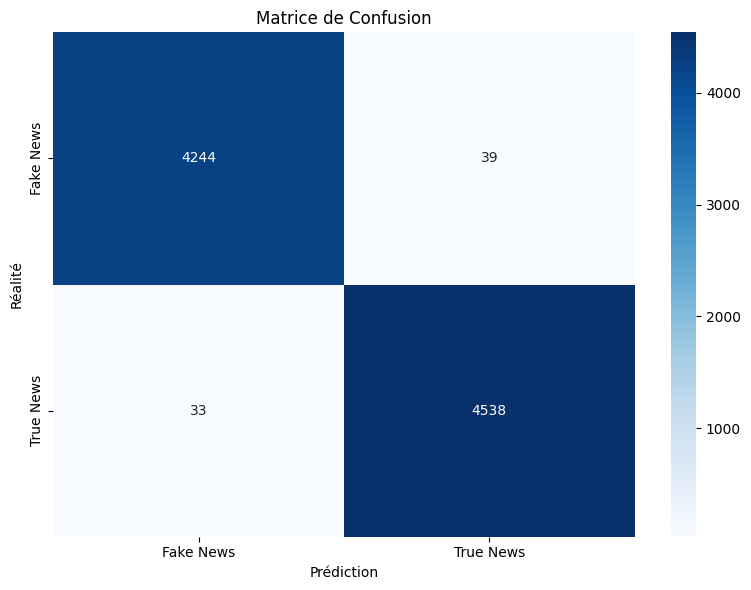

277/277 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step


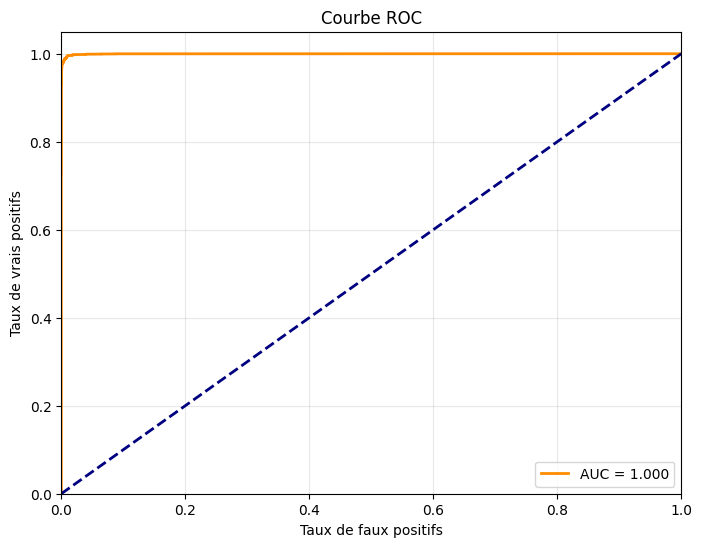

277/277 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step


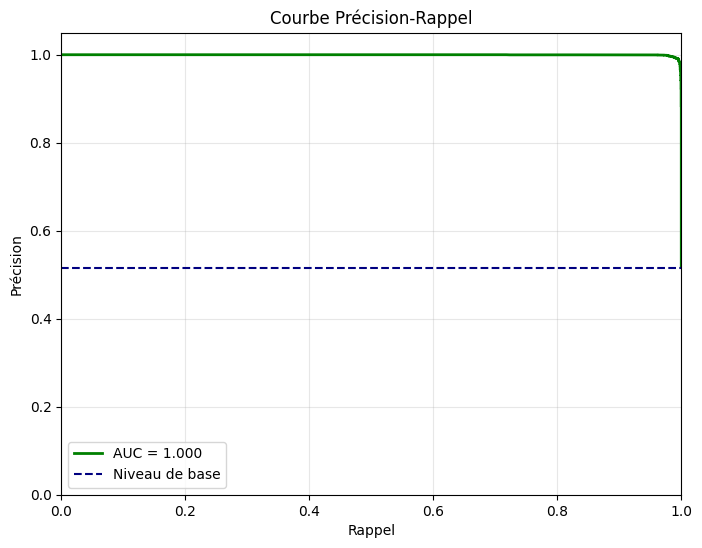

277/277 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step
277/277 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step


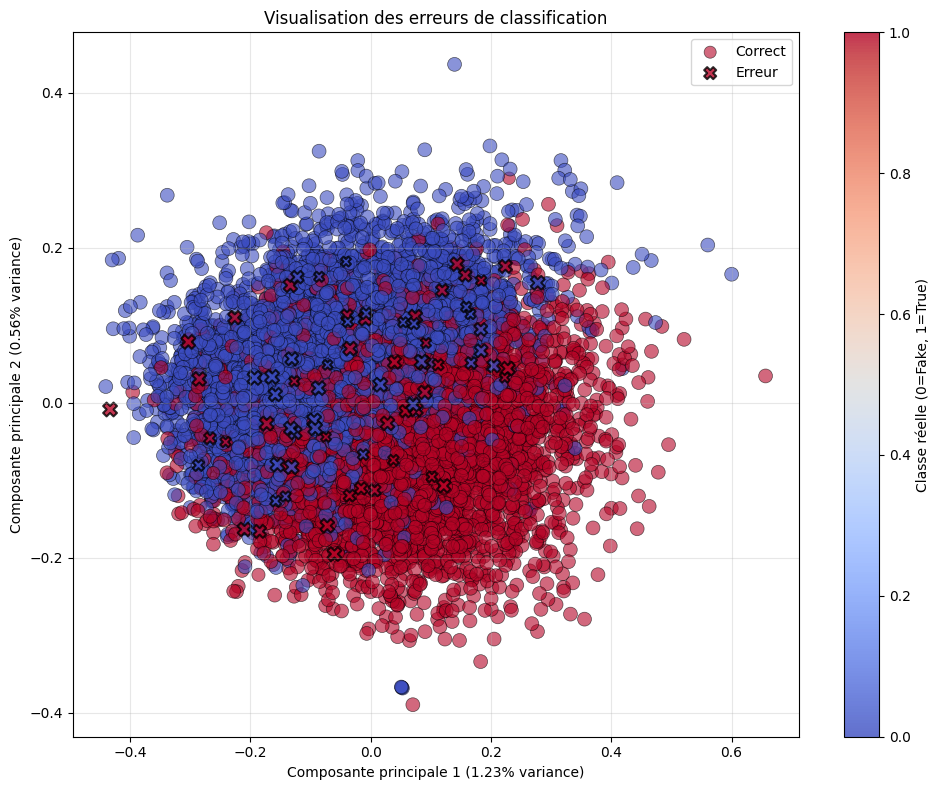

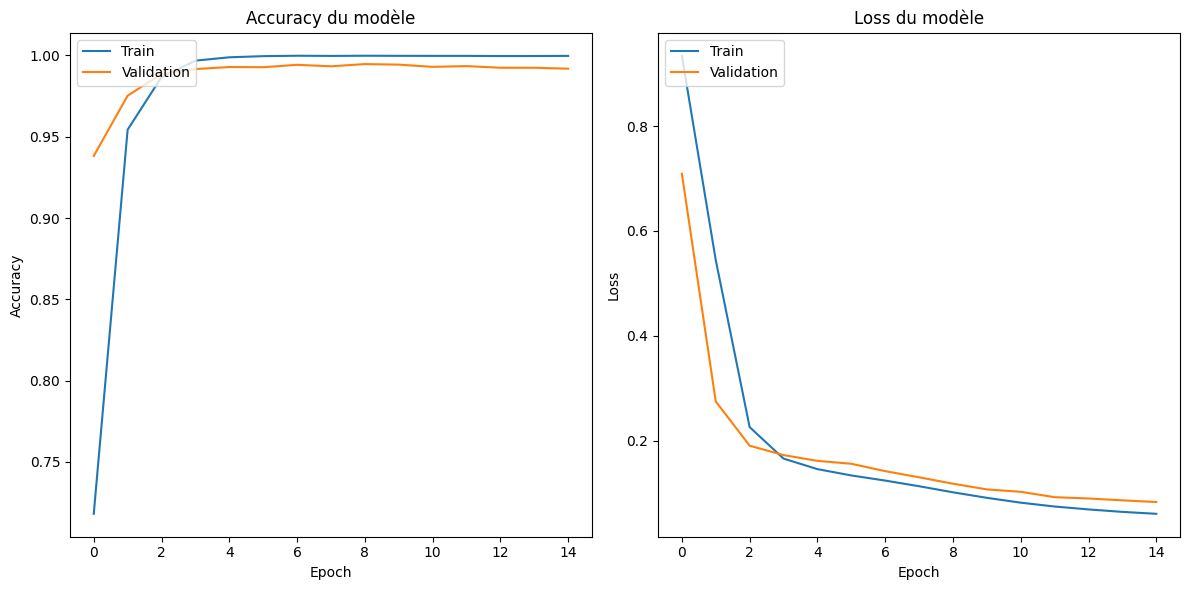

In [20]:
plot_confusion_matrix_dl(model_dl, X_test, y_test)
plot_roc_curve_dl(model_dl, X_test, y_test)
plot_precision_recall_curve_dl(model_dl, X_test, y_test)
plot_classification_errors_dl(model_dl, X_test, y_test)
plot_learning_curves(history)